In [2]:
import pandas as pd
import numpy as np

# Buoy Data Cleanup

In [35]:
dfs = []
for year in range(2000, 2005):
    df = pd.read_csv(f'../data/sgnw3h{year}.csv', comment='#', header=None)
    cols = ["YY","MM","DD","hh","WDIR","WSPD","GST","WVHT","DPD","APD","MWD","PRES","ATMP","WTMP","DEWP","VIS","TIDE"]
    df.columns = cols

    dfs.append(df)

first_df = pd.concat(dfs)
first_df['mm'] = [0] * len(first_df)
first_df.head()

dfs = []
for year in range(2005, 2025):
    df = pd.read_csv(f'../data/sgnw3h{year}.csv', comment='#', header=None)
    cols = ["YY","MM","DD","hh","mm","WDIR","WSPD","GST","WVHT","DPD","APD","MWD","PRES","ATMP","WTMP","DEWP","VIS","TIDE"]
    df.columns = cols
    dfs.append(df)

second_df = pd.concat(dfs)
df = pd.concat([first_df, second_df])

df = df.rename(columns={
    'YY': 'year',
    'MM': 'month',
    'DD': 'day',
    'hh': 'hour'
})

df['day'] = pd.to_datetime(df[['year','month','day']])

df = df[['day', 'WDIR', 'WSPD', 'PRES', 'ATMP', 'WTMP', 'DEWP']]
df = df.set_index('day')

df = df[['WDIR','WSPD','PRES','ATMP','WTMP','DEWP']].resample('D').mean(numeric_only=True)

# Clean pressure
df.loc[df['PRES'] > 1050, 'PRES'] = np.nan
df.loc[df['PRES'] < 980, 'PRES'] = np.nan
df['PRES'] = df['PRES'].interpolate(limit=7, limit_direction='both', method='linear')


# Clean WDIR
df.loc[df['WDIR'] > 360, 'WDIR'] = np.nan
df['WDIR'] = df['WDIR'].interpolate(limit=1, limit_direction='both', method='linear')

# Add onshore indicator
def onshore(wdir):
    return int(60 <= wdir <= 120)
df['I_onshore'] = df['WDIR'].apply(onshore)

# Clean ATMP
df.loc[df['ATMP'] > 108, 'ATMP'] = np.nan
df['ATMP'] = df['ATMP'].interpolate(method='linear')

# Clean WTMP
df.loc[df['WTMP'] > 80, 'WTMP'] = np.nan

dfnp = df.dropna(subset=['WSPD'])
df = df.dropna(subset=['PRES', 'WSPD'])

df.head()

,WDIR,WSPD,PRES,ATMP,WTMP,DEWP,I_onshore
day,,,,,,,
2000-01-01,181.333333,5.445833,1013.741667,2.475000,1.195833,-1.179167,0
2000-01-02,159.833333,5.579167,1005.933333,4.058333,1.425000,3.883333,0
2000-01-03,117.208333,9.258333,1014.737500,0.425000,0.983333,-0.158333,1
2000-01-04,240.083333,3.670833,1008.258333,-2.341667,0.362500,-3.658333,0
2000-01-05,257.000000,4.929167,1023.720833,-6.066667,0.145833,-9.558333,0


In [38]:
dfnp = dfnp.drop(columns=['PRES'])
dfnp.to_csv("../data/sheb_buoy_no_pres.csv")

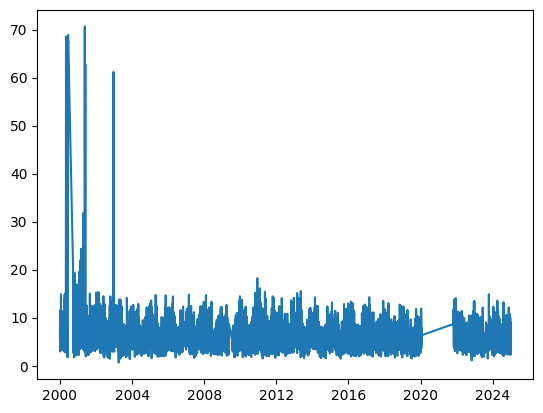

In [82]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['WSPD'].values)
plt.show()

In [36]:
df.to_csv('../data/sheb_buoy.csv')

# Weather Station Cleanup

In [85]:
dfs = []
for year in [2000, 2005, 2010, 2015, 2020]:
    filepath = f"../data/sheb_{year}-{year+4}.csv"
    df = pd.read_csv(filepath)
    dfs.append(df)


df = pd.concat(dfs)
df['day'] = pd.to_datetime(df['day'])
df = df.set_index('day')


df['doy'] = df.index.dayofyear

df['precip_in'] = df['precip_in'].fillna(0.)
df.loc[df['precip_in'] <= 0.001, 'precip_in'] = 0

df['rain_today'] = (df['precip_in'] != 0).astype(int)
df['rain_yesterday'] = (df['precip_in'].shift(1) != 0).astype(int)

for col in ['max_temp_f', 'min_temp_f', 'max_dewpoint_f', 'min_dewpoint_f', 'precip_in', 'avg_wind_speed_kts','avg_wind_drct', 'min_rh', 'avg_rh', 'max_rh', 'max_wind_speed_kts','max_wind_gust_kts']:
    df[col] = df[col].interpolate(method='linear')

df.drop(columns=['snow_in', 'srad_mj', 'max_wind_gust_kts'], inplace=True)

In [34]:
df.to_csv('../data/sheb_weather_station.csv')

In [86]:
df.columns

Index(['station', 'max_temp_f', 'min_temp_f', 'max_dewpoint_f',
       'min_dewpoint_f', 'precip_in', 'avg_wind_speed_kts', 'avg_wind_drct',
       'min_rh', 'avg_rh', 'max_rh', 'max_wind_speed_kts', 'climo_high_f',
       'climo_low_f', 'climo_precip_in', 'doy', 'rain_today',
       'rain_yesterday'],
      dtype='object')

# Water Temp Data

In [32]:
wdf = pd.read_csv("../data/GLSEA.csv")

wdf = wdf[['time', 'sst']]
wdf['time'] = pd.to_datetime(wdf['time']).dt.date
wdf = wdf.rename(columns={
    'time':'day'
})

wdf['day'] = pd.to_datetime(wdf['day'])
wdf = wdf.set_index('day')

wdf = wdf.resample('D').mean(numeric_only=True)

wdf.to_csv("../data/watertemp.csv")

<Axes: xlabel='day'>

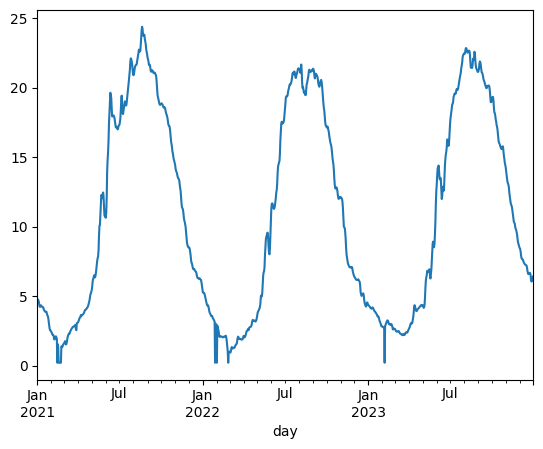

In [33]:
wdf['sst'].plot()